## Port of Compound Eye Autopilot
This is an attempt to port the CV autopilot written in C++ shown here: https://github.com/compound-eye/windshield/blob/master/think/Compute.cpp to python. 

In [57]:
import os
import cv2
import numpy as np
import random

In [58]:
import matplotlib
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline

In [67]:
dir_path = '/home/wroscoe/donkey_data/sessions/ac_1130/'
images = os.listdir(dir_path)
img_paths = [os.path.join(dir_path, i) for i in images]

random.shuffle(img_paths)

img_arr = np.array([cv2.imread(p) for p in img_paths[:5]])

In [68]:
def show_imgs(img_arr, cmap=None):
    fig, ax = plt.subplots(1, img_arr.shape[0], figsize=(15, 6),
                             subplot_kw={'adjustable': 'box-forced'})

    axoff = np.vectorize(lambda ax:ax.axis('off'))
    axoff(ax)

    for i, img in enumerate(img_arr):

        ax[i].imshow(img, cmap=cmap)

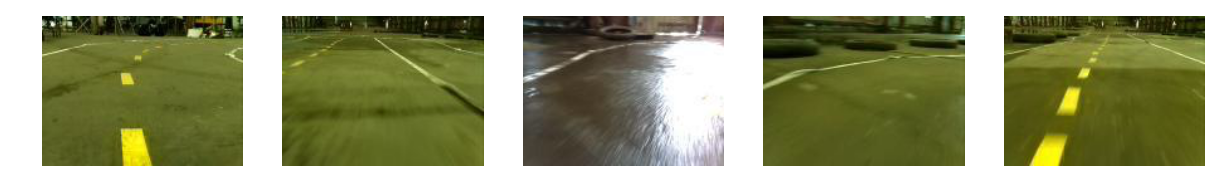

In [69]:
show_imgs(img_arr)

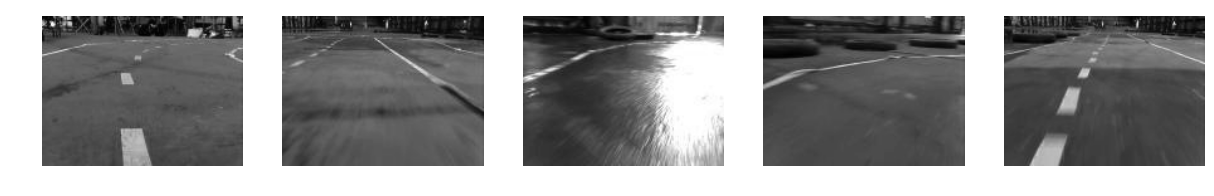

In [70]:
gray_arr = np.array([cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in img_arr])
show_imgs(gray_arr, cmap='gray')

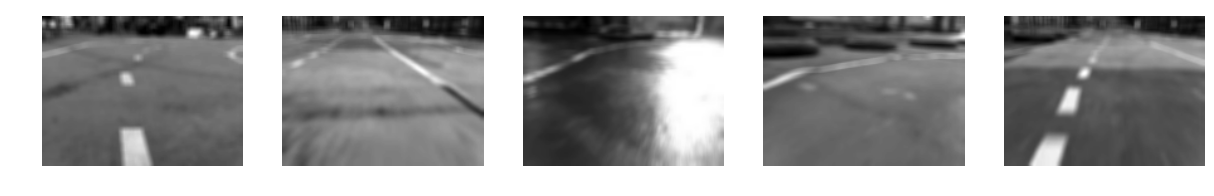

In [71]:
blur_arr = np.array([cv2.blur(arr,(5,5)) for arr in gray_arr])
show_imgs(blur_arr, cmap='gray')

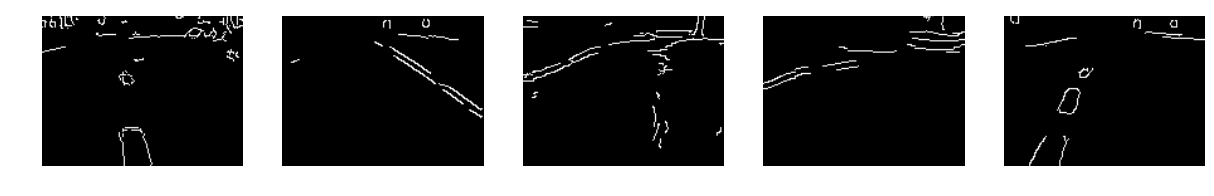

In [72]:
CANNY_THRESHOLD1 = 100
CANNY_THRESHOLD2 = 130

canny_arr = np.array([cv2.Canny(arr, CANNY_THRESHOLD1, CANNY_THRESHOLD2) for arr in blur_arr])
show_imgs(canny_arr, cmap='gray')

Found 1 lines.


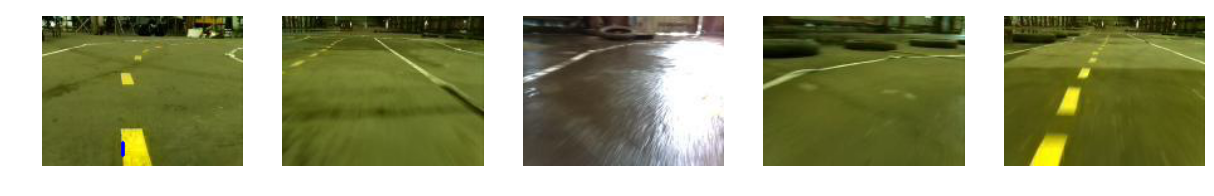

In [73]:
img_height = 120
img_width = 160

HOUGH_THRESHOLD = int(round(img_height * img_width / 6500))
min_line_length = img_height / 100
max_gap = 10
rho = .4
theta = .9

line_arr = []
line_count = 0
for i, canny in enumerate(canny_arr):
    lines = cv2.HoughLinesP(canny, rho, theta, HOUGH_THRESHOLD, min_line_length, max_gap)
    img = img_arr[i]
    if lines is not None:
        for line in lines: 
            x1, y1, x2, y2 = line[0]
            cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
            line_count += 1

    line_arr.append(img)
    
line_arr = np.array(line_arr)

print('Found %s lines.' %line_count)

show_imgs(line_arr)


### Confused after this part. 

In [ ]:
Hdata = np.array([
                [0.6675041881879467,    -0.6301258503975012,  49.80068082287637],
                [-0.006612602777747778,   0.7948226618810976,  -7.541413704343782],
                [-8.961567957315749e-05, -0.003982602759291037, 1,]
                ])


mid_left = img_width * .5
mid_right = img_width * .4